# Eksploracja zbioru znaków phcd

Naszym pierwszym zadaniem będzie rozpakowanie pliku .rar ze zbiorem danych i ustalenie struktury plików oraz w jakiej ścieżce możemy się spodziewać zdjęć znaków.
 




In [ ]:
! pip install wandb && wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 6.6 MB/s 
     |████████████████████████████████| 157 kB 12.3 MB/s 
     |████████████████████████████████| 181 kB 55.0 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 157 kB 42.2 MB/s 
     |████████████████████████████████| 157 kB 42.1 MB/s 
     |████████████████████████████████| 157 kB 43.4 MB/s 
     |████████████████████████████████| 157 kB 44.2 MB/s 
     |████████████████████████████████| 156 kB 40.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=063739065b2c9bdc7f9ef33b9f8829f8eebdb8a06b7b1bee94589e3368f6dd42
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/w

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import pathlib 
import os
import PIL
import PIL.Image
import tensorflow as tf
import wandb

In [ ]:
! mkdir /content/data && \
  cp drive/MyDrive/praca\ mgr/phcd.rar /content/data && \
  cd /content/data && unrar x /content/data/phcd.rar && \
  mkdir images && cd images && unrar x ../phsf.rar

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Extracting  znaki/png/9/9_0745_95_M_2B.png                                99%  OK 
Extracting  znaki/png/9/9_0745_98_M_2E.png                                99%  OK 
Extracting  znaki/png/9/9_0746_95_M_2B.png                                99%  OK 
Extracting  znaki/png/9/9_0746_98_M_2E.png                                99%  OK 
Extracting  znaki/png/9/9_0747_95_M_2B.png                                99%  OK 
Extracting  znaki/png/9/9_0747_98_M_2E.png                                99%  OK 
Extracting  znaki/png/9/9_0748_97_M_2B.png                                99%  OK 
Extracting  znaki/png/9/9_0748_98_M_2E.png                                99%  OK 
Extracting  znaki/png/9/9_0749_97_M_2B.png                                99%  OK 
Extracting  znaki/png/9/9_0749_97_M_2E.png                                99%  OK 
Extracting  zna

In [ ]:
data_dir = pathlib.Path("/content/data/images/znaki/png")
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

558155


## Słownik z nazwami klas oraz przykładowe skany znaków

In [ ]:
signs_dictionary = { 
    # numbers
    "0": "0", "1": "1", "2": "2", "3": "3", "4": "4", "5": "5", "6": "6", "7": "7", "8": "8", "9": "9",

    # latin characters
    "10": "a", "11": "b", "12": "c", "13": "d", "14": "e", "15": "f", "16": "g", "17": "h", "18": "i", "19": "j",
    "20": "k", "21": "l", "22": "m", "23": "n", "24": "o", "25": "p", "26": "q", "27": "r", "28": "s", "29": "t",
    "30": "u", "31": "v", "32": "w", "33": "x", "34": "y", "35": "z", 

    "36": "A", "37": "B", "38": "C", "39": "D", "40": "E", "41": "F", "42": "G", "43": "H", "44": "I", "45": "J",
    "46": "K", "47": "L", "48": "M","49": "N", "50": "O", "51": "P", "52": "Q", "53": "R", "54": "S", "55": "T",
    "56": "U", "57": "V", "58": "W", "59": "X", "60": "Y", "61": "Z",

    # polish characters
    "62": "ą", "63": "ć", "64": "ę", "65": "ł", "66": "ń", "67": "ó", "68": "ś", "69": "ź", "70": "ż",
    "71": "Ą", "72": "Ć", "73": "Ę", "74": "Ł", "75": "Ń", "76": "Ó", "77": "Ś", "78": "Ź", "79": "Ż",

    # special characters
    "80": "+", "81": "-", "82": ":", "83": ";", "84": "$", "85": "!", "86": "?", "87": "@", "88": "."
}

In [ ]:
from wandb.keras import WandbCallback

wandb.init(project="phcd_numbers")

def create_wandb_plot(x_data=None, y_data=None, x_name=None, y_name=None, title=None, log=None, plot="line"):
    '''Create and save lineplot/barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    data = [[label, val] for (label, val) in zip(x_data, y_data)]
    table = wandb.Table(data=data, columns = [x_name, y_name])
    
    if plot == "line":
        wandb.log({log : wandb.plot.line(table, x_name, y_name, title=title)})
    elif plot == "bar":
        wandb.log({log : wandb.plot.bar(table, x_name, y_name, title=title)})
    elif plot == "scatter":
        wandb.log({log : wandb.plot.scatter(table, x_name, y_name, title=title)})
        
        
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None):
    '''Create and save histogram in W&B Environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title=title)})

wandb: Currently logged in as: gratkadlafana. Use `wandb login --relogin` to force relogin


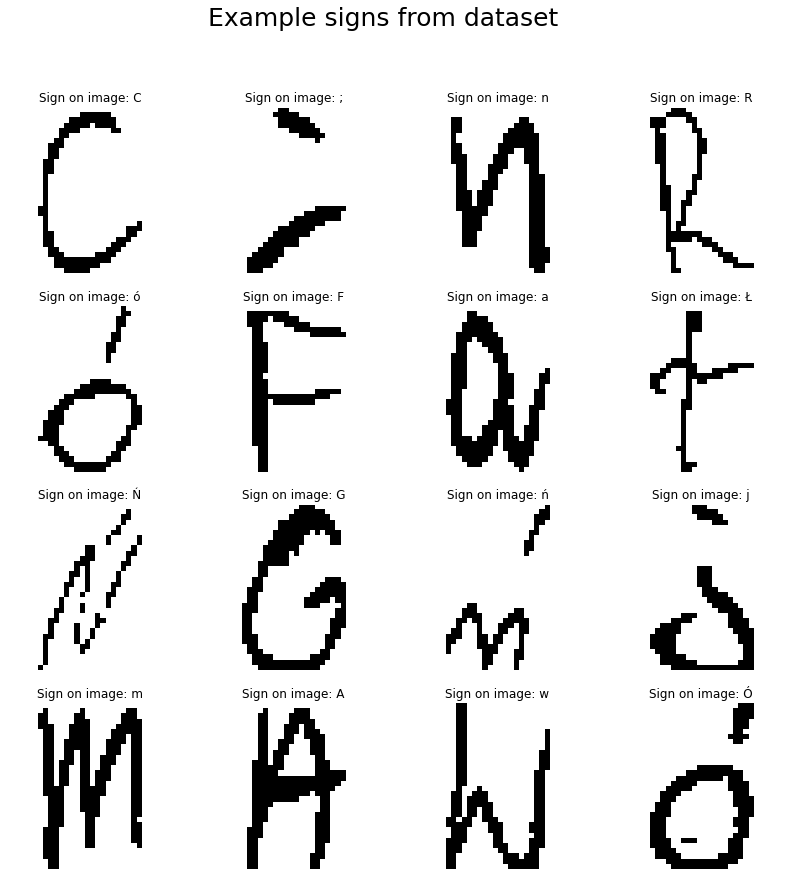

In [ ]:
signs = list(data_dir.glob('*/*.png'))


examples = np.random.choice(signs, 16)

fig, ax = plt.subplots(4, 4, figsize=(14,14))

fig.suptitle("Example signs from dataset", fontsize=25)
for sign_path, axis in zip(examples, ax.flatten()): 
  example_sign = signs_dictionary[
      sign_path.stem.split("_")[0]
  ]

  example_image = PIL.Image.open(sign_path)

  axis.imshow(example_image, cmap='gray')
  axis.set_title(f"Sign on image: {example_sign}")
  axis.axis('off')
plt.show()

In [ ]:
example_image = PIL.Image.open(examples[0])

picture = np.array(example_image)

picture.shape

(32, 32)

## Reading dataset - only numbers

In [ ]:
import pathlib
import shutil

main_path = pathlib.Path("/content/data/images/znaki/numbers")
main_path.mkdir(parents=True, exist_ok=True)

for i in range(10):
  new_path = main_path / str(i)
  number_path = pathlib.Path(f"/content/data/images/znaki/png/{i}")  
  number_path.rename(new_path)

! ls /content/data/images/znaki/numbers

0  1  2  3  4  5  6  7	8  9


In [ ]:
data_dir = "/content/data/images/znaki/numbers"


color_mode = "grayscale"
number_colour_layers = 1
IMAGE_SIZE = (32, 32)
IMAGE_SHAPE = IMAGE_SIZE + (number_colour_layers,)
BATCH_SIZE = 128

def get_image_data(data_path, color_mode, image_size, seed = None, subset = None, validation_split = None):
    if subset:
        validation_split = 0.2
    raw_data_set = tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        color_mode=color_mode,
        image_size=image_size,
        seed=seed,
        validation_split=validation_split, 
        subset=subset
    )
    
    raw_data_set.class_names.sort()
    
    return {
        "data": raw_data_set.cache().prefetch(
        buffer_size = tf.data.experimental.AUTOTUNE
        ),
        "classNames": raw_data_set.class_names
    }

training_ds = get_image_data(
    training_data_path,
    color_mode,
    image_size,
    SEED,
    subset = "training"
)

validation_ds = get_image_data(
    training_data_path,
    color_mode,
    image_size,
    SEED,
    subset = "validation"
)

Found 61647 files belonging to 10 classes.
Using 49318 files for training.


In [ ]:
class_names = train_ds.class_names
NUMBER_OF_CLASSES = len(train_ds.class_names)

print(f"There are {NUMBER_OF_CLASSES} classes: {class_names}")

There are 10 classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


ValueError: ignored

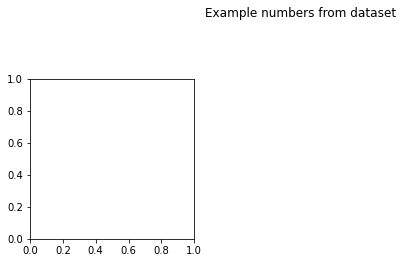

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  plt.suptitle("Example numbers from dataset")
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().reshape((32,32, 3)).astype("uint8"), cmap='gray')
    class_idx = np.flatnonzero(labels[i]).item()
    plt.title(train_ds.class_names[class_idx])
    plt.axis("off")

img_path = "./example_numbers.png"
plt.savefig(img_path)

cover = plt.imread(img_path)
wandb.log({"example_numbers": wandb.Image(cover)})

In [ ]:
# cache dataset for performance over folds

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 32, 32, 3)
(128, 10)


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Build model

In [ ]:
NUMBER_OF_CLASSES

10

In [ ]:
from wandb.keras import WandbCallback


wandb.config = {
  "learning_rate": 0.0001,
  "epochs": 5,
  "batch_size": 128
}

model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUMBER_OF_CLASSES),
    ]
)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam(learning_rate=wandb.config['learning_rate'])

model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])

history = model.fit(
  normalized_train_ds,
  validation_data=normalized_val_ds,
  batch_size=wandb.config['batch_size'],
  epochs=wandb.config['epochs'],
  callbacks=[
      WandbCallback(), 
      tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
        baseline=None, restore_best_weights=True
        )]
)

wandb: WARNING Unable to compute FLOPs for this model.


Epoch 1/5


InvalidArgumentError: ignored

In [ ]:
score = model.evaluate(val_ds, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 9.606269836425781
Test accuracy: 0.06780760735273361


In [ ]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

test_images = val_ds.take(1)


for img, label in test_images:
  for i in range(10):
    prediction = probability_model.predict(img)
    print(label[i])
    print(np.argmax(prediction[0]))


tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
1
tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
1
tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
1
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(10,), dtype=float32)
1
tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)
1
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(10,), dtype=float32)
1
tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)
1
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
1
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(10,), dtype=float32)
1
tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
1
